# Minigrid environment

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
from gym_minigrid import minigrid_env
import numpy as np
import cv2
import random
import seaborn as sns
sns.set_theme(style="darkgrid")

pygame 2.5.1 (SDL 2.28.2, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload

In [3]:
env = minigrid_env.Env(size=15, agent_view_size=5, num_tiles=25)
observation, info = env.reset(seed=42)

In [4]:
%autoreload 2

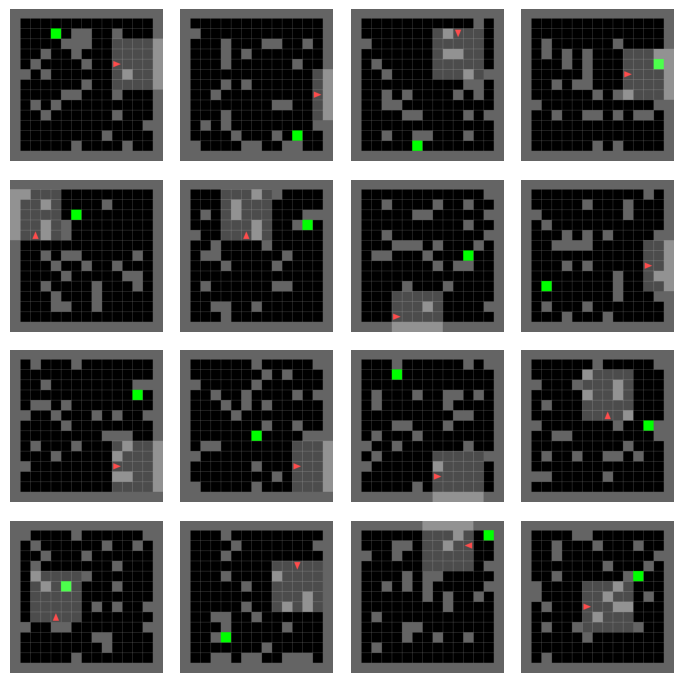

In [5]:
plt.figure(figsize=(7,7))

# Draw 16 environments
for i in range(16):
    plt.subplot(4, 4, i+1)
    _ = env.reset(seed=i)
    plt.imshow(env.get_frame())
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.finder.breadth_first import BreadthFirstFinder

def replace_char(char):
    if char == '+' or char == '-' or char == '|' or char == '#':
        return [125, 125, 125]
    elif char == 's':
        return [255, 0, 0]
    elif char == 'e':
        return [0, 255, 0]
    elif char == 'x':
        return [0, 0, 255]
    else:
        return [0, 0, 0]

def get_shortest_path(grid, pos):
    """Get the shortest path from the start to the end

    Args:
    grid (np.array): 2D grid where 0 is free space and 1 is obstacle
    pos (tuple): Start and end position in the grid (start_x, start_y, end_x, end_y)
    """
    start, end = pos[:2], pos[2:]
    maze = np.abs(grid - 1)

    # Ensure start and end are free
    #maze[start[0], start[1]] = 1
    #maze[end[0], end[1]] = 1
    
    grid = Grid(matrix=maze)
    start = grid.node(start[0], start[1])
    end = grid.node(end[0], end[1])
    
    finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
    path, runs = finder.find_path(start, end, grid)

    return path

Generate random grids

In [33]:
grids = []
pos = []
path_lengths = []
num_grids = 50_000

# Generate a bunch of random grids
for i in range(num_grids):
    env.reset(seed=i, num_tiles=(50, 50))
    grid = env.get_full_render(highlight=False, tile_size=1)
    grids.append(grid)
    positions = np.ravel((env.agent_pos, env.goal_pos))
    pos.append(positions)

    maze = np.ceil(grid/255).mean(axis=-1).astype(int)
    maze[positions[1], positions[0]] = 0
    maze[positions[3], positions[2]] = 0

    path = get_shortest_path(maze, positions)
    path_lengths.append(len(path))

    print(f"Generated {i+1}/{num_grids} grids", end="\r")

grids = np.array(grids)
pos = np.array(pos)
path_lengths = np.array(path_lengths)

Text(0, 0.5, 'Frequency')

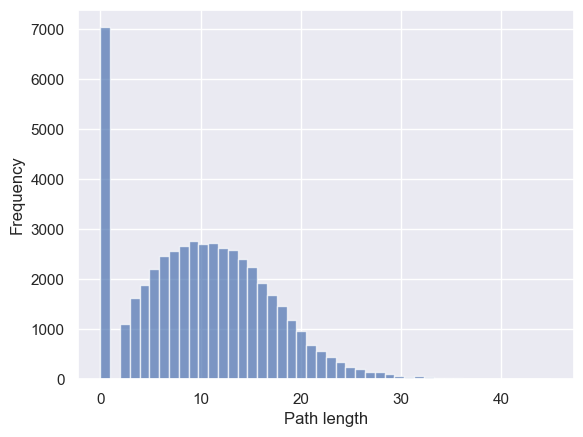

In [35]:
# Plot path length distribution
hist = plt.hist(path_lengths, bins=46, alpha=0.7)
plt.xlabel("Path length")
plt.ylabel("Frequency")

Generate dataset with uniform distribution of path lengths

In [48]:
# Create 10 bins of path lengths from 1 to 30
num_bins = 10
bins = np.linspace(1, 30, num_bins+1)
bins

array([ 1.        ,  4.22222222,  7.44444444, 10.66666667, 13.88888889,
       17.11111111, 20.33333333, 23.55555556, 26.77777778, 30.        ])

In [ ]:
grids = []
pos = []
path_lengths = []
NUM_GRIDS = 50_000

NUM_GRIDS_PER_BIN = NUM_GRIDS // num_bins

# Generate a bunch of random grids
for i in range(num_bins):
    for j in range(NUM_GRIDS_PER_BIN):

        path_length = -1
        while (path_length < bins[i] or path_length > bins[i+1]):

            env.reset(seed=i, num_tiles=(25, 25))
            grid = env.get_full_render(highlight=False, tile_size=1)
            positions = np.ravel((env.agent_pos, env.goal_pos))

            maze = np.ceil(grid/255).mean(axis=-1).astype(int)
            maze[positions[1], positions[0]] = 0
            maze[positions[3], positions[2]] = 0

            path_length = len(get_shortest_path(maze, positions))
            
        print(f"Generated {i+1}/{num_bins} bins, {j+1}/{NUM_GRIDS_PER_BIN} grids", end="\r")
        grids.append(grid)
        pos.append(positions)
        path_lengths.append(path_length)            

grids = np.array(grids)
pos = np.array(pos)
path_lengths = np.array(path_lengths)

(0.0, 43.0)

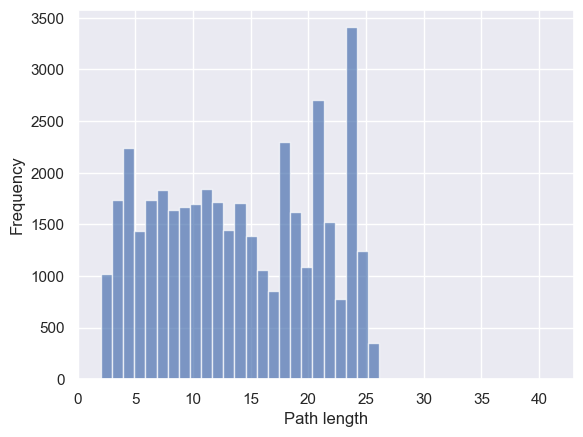

In [63]:
# Plot path length distribution
hist = plt.hist(path_lengths, bins=29, alpha=0.7)
plt.xlabel("Path length")
plt.ylabel("Frequency")

plt.xlim(0,43)

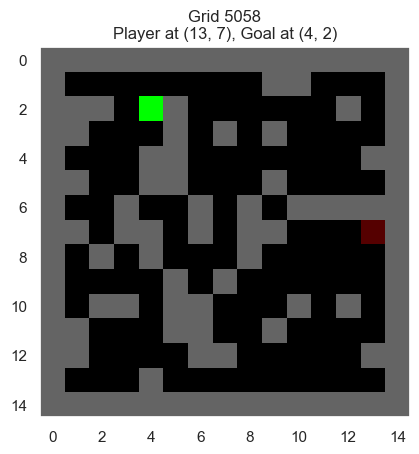

In [532]:
i = random.randint(0, num_grids-1)

plt.imshow(grids[i])
plt.title(f"Grid {i}\nPlayer at {pos[i][0]}, Goal at {pos[i][1]}")
plt.grid(False)
plt.show()

_______

Create dataset

In [81]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class GridsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, grids, pos, img=None):
        self.grids = grids
        self.pos = pos
        self.img = img

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, index):
        x = TF.to_tensor(self.grids[index])
        y = torch.tensor(self.pos[index])
        if self.img is not None:
            img = TF.to_tensor(self.img[index])
            return x, y, img
        return x, y

In [67]:
X = grids

Y = np.array(pos).astype(np.float32)
# Reshape to (num_samples, 4)
Y = Y.reshape(Y.shape[0], -1)
# Set center to 0,0 and scale to [-1, 1]
Y -= 7
Y /= 7

In [596]:
# Save the data
np.save("grids.npy", X)
np.save("pos.npy", Y)
np.save("path_lengths.npy", path_lengths)

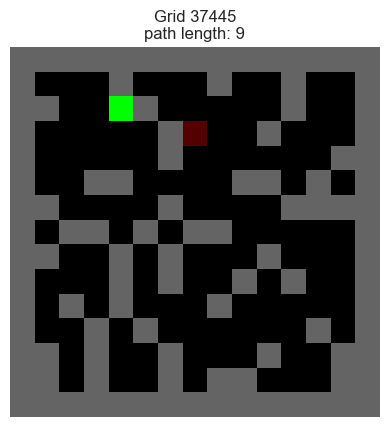

In [597]:
i = random.randint(0, len(X)-1)
path_length = path_lengths[i]
plt.imshow(X[i])
plt.axis('off')
plt.title(f"Grid {i}\npath length: {path_length}")
plt.grid(False)
plt.show()

In [82]:
# Load the data
X = np.load("grids.npy")
Y = np.load("pos.npy")
path_lengths = np.load("path_lengths.npy")

# Remove outer walls
X = X[:, 1:-1, 1:-1, :]

In [83]:
X.shape, Y.shape, path_lengths.shape

((40000, 13, 13, 3), (40000, 4), (40000,))

In [84]:
idx = 0

points = []

for idx in range(X.shape[0]):
    # Remove player and goal from the grid
    X[idx, Y[idx, 1], Y[idx, 0], :] = [0, 0, 0]
    X[idx, Y[idx, 3], Y[idx, 2], :] = [0, 0, 0]

    # Extract coordinates of non-zero elements
    x, y = np.where(X[idx].mean(axis=-1) != 0)
    points_ = np.array(list(zip(x, y)))
    # Add player and goal to the points
    points_ = np.concatenate([points_, Y[idx].reshape(-1, 2)])
    points.append(points_)

    if points_.shape[0] != 27:
        print(idx, points_.shape)
        break

    print(f"Processed {idx+1}/{X.shape[0]} grids", end="\r")

points = np.array(points)

In [85]:
X_img = np.copy(X)
X = points.astype(np.float32)
Y = path_lengths.astype(np.float32)

In [86]:
X_img.shape, X.shape, Y.shape

((40000, 13, 13, 3), (40000, 27, 2), (40000,))

In [87]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train)
val_dataset = GridsDataset(X_val, Y_val)

In [88]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val, X_img_train, X_img_val, = train_test_split(X, Y, X_img, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train, X_img_train)
val_dataset = GridsDataset(X_val, Y_val, X_img_val)

Train model

In [14]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
self.encoder = nn.Sequential(
            nn.Conv2d(image_channels + 1, 24, kernel_size=3, stride=1),  # Add conditional input
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)

In [90]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, latent_dim * 2, bias=False)  # Two outputs for mean and variance
        )

        # Test: Convolutional encoder
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(input_dim + 1, 24, kernel_size=3, stride=1),  # Add conditional input
        #     nn.ReLU(),
        #     nn.Conv2d(24, 32, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 48, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.Conv2d(48, 64, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     Flatten()
        # )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim//2, bias=False),  # Add conditional input
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim - 1, bias=False),  # Remove conditional input
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x, y):
        xy = torch.cat((x, y), dim=-1)
        # Encode
        z_params = self.encoder(xy)
        mu = z_params[:, :latent_dim]
        logvar = z_params[:, latent_dim:]
        z = self.reparameterize(mu, logvar)

        # Concatenate the last element of x with z
        z = torch.cat([z, x[:,-1].unsqueeze(1)], dim=-1)
        
        # Decode
        x_hat = self.decoder(z)
        
        return x_hat, mu, logvar

In [91]:
# Loss function
def loss_function(x_hat, x, mu, logvar):

    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_divergence

In [96]:
def train_vae(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, early_stopping={'patience': 5, 'min_delta': 0.001}):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True, min_lr=1e-6)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for x, y, x_img in train_loader:
            optimizer.zero_grad()

            # Flatten the input data if it's not already flattened
            x = x.view(x.size(0), -1)
            x = x.to(device)

            y = y.view(y.size(0), -1)
            y = y.to(device)

            x_hat, mu, logvar = model(x, y)
            loss = loss_function(x_hat, x, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y, x_img in val_loader:
                x = x.view(x.size(0), -1)
                x = x.to(device)

                y = y.view(y.size(0), -1)
                y = y.to(device)

                xy = torch.cat((x, y), dim=-1)

                x_hat, mu, logvar = model(x, y)
                loss = loss_function(x_hat, x, mu, logvar)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.4f}, val_loss: {val_loss:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break
            
        scheduler.step(val_loss)

    print('Training finished.')

    return loss_history

In [97]:
# Number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

input_dim = (25 + 2)*2 + 1  # (25 blocks + 1 player position + 1 goal position) + 1 complexity
hidden_dim = 2048
latent_dim = 16
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)

print(vae_model)
print(f'The model has {count_parameters(vae_model):,} trainable parameters')

Device: cuda
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=55, out_features=2048, bias=False)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=False)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=32, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=17, out_features=1024, bias=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2048, bias=False)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=54, bias=False)
  )
)
The model has 4,467,712 trainable parameters


In [99]:
batch_size = 32
num_epochs = 2_000
early_stopping = {'patience': 15, 'min_delta': 0.05}

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train VAE
loss_history = train_vae(vae_model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        learning_rate=1e-3,
                        early_stopping=early_stopping)

Epoch [1/2000], train_loss: 293.2183, val_loss: 213.7314
Epoch [2/2000], train_loss: 206.0019, val_loss: 195.3949
Epoch [3/2000], train_loss: 189.3612, val_loss: 184.2185
Epoch [4/2000], train_loss: 177.1731, val_loss: 177.1287
Epoch [5/2000], train_loss: 168.2604, val_loss: 167.6762


KeyboardInterrupt: 

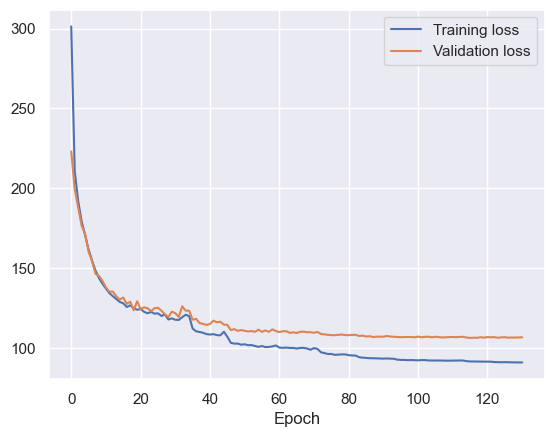

In [67]:
# Plot training and validation loss
plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
# plt.ylim(20,50)

In [146]:
# Save VAE model
torch.save(vae_model.state_dict(), f"models/VAE_MiniGrid_latent-dim-{latent_dim}.pt")

In [68]:
# input_dim = (25 + 2)*2 + 1  # (25 blocks + 1 player position + 1 goal position) + 1 complexity
# hidden_dim = 256
# latent_dim = 32
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load VAE model
# vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device) # GPU
# vae_model.load_state_dict(torch.load(f"models/VAE_MiniGrid_latent-dim-{latent_dim}.pt"))
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=55, out_features=2048, bias=False)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=False)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=32, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=17, out_features=1024, bias=False)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2048, bias=False)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=54, bias=False)
  )
)

Plot reconstructed grids

In [69]:
# Generate a 15x15 image from 1D vector
def generate_grid_image(points_, start_goal=True):

    points = np.copy(points_)
    points = np.clip(points, 0, 13)
    points += 1  # Because of outer walls

    points[-2:] = np.clip(points[-2:], 1, 13)  # Player and goal

    img = np.zeros((15, 15, 3), dtype=np.uint8)

    # Outer walls
    img[0, :] = 125
    img[-1, :] = 125
    img[:, 0] = 125
    img[:, -1] = 125

    # Blocks
    for x, y in points[:-2]:
        img[y, x] = 125

    if start_goal:
        # Player
        img[points[-2, 1], points[-2, 0], :] = [255, 0, 0]
        # Goal
        img[points[-1, 1], points[-1, 0], :] = [0, 255, 0]

    return img

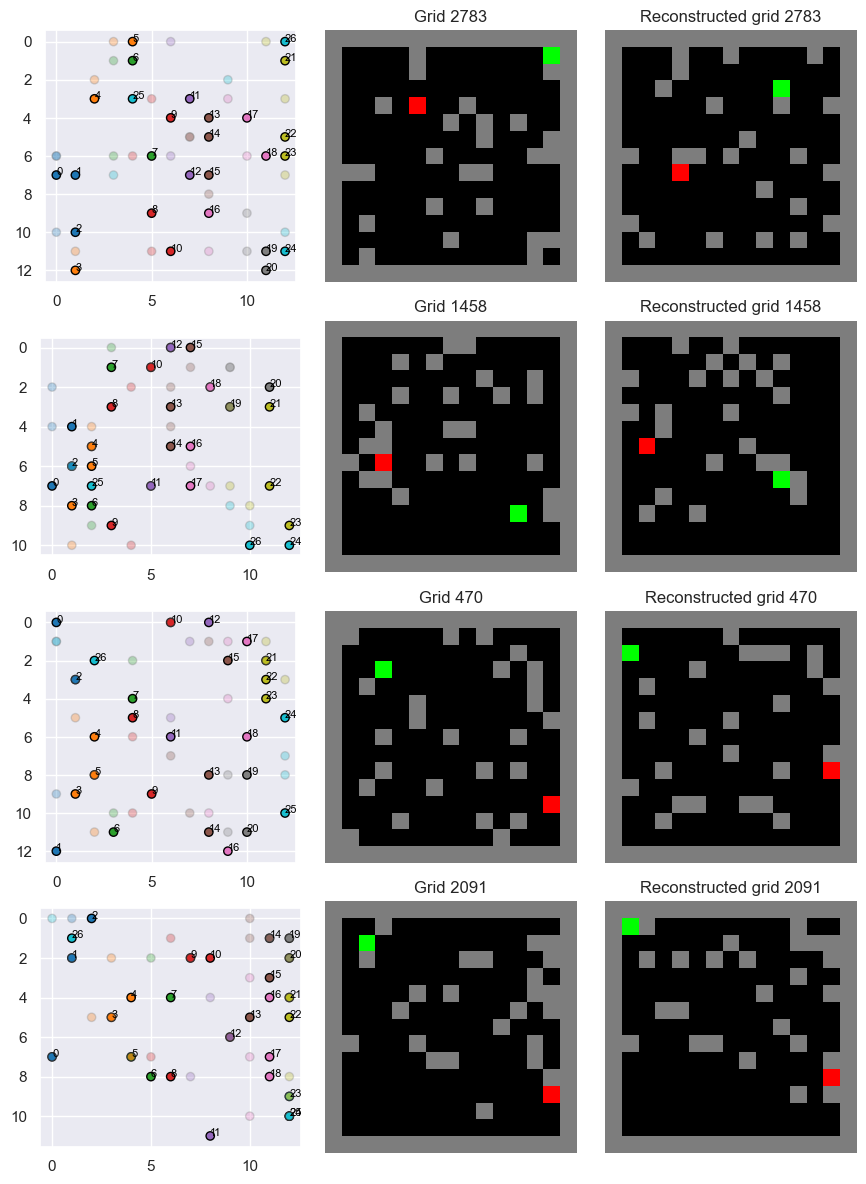

In [70]:
n_images = 4

plt.figure(figsize=(9, int(n_images*3)))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0]
    y = val_dataset[j][1]
    x = x.view(1, -1).to(device)
    y = y.view(1, -1).to(device)
    xy = torch.cat((x, y), dim=-1)
    recon_x, _, _ = vae_model.to(device)(xy)

    x = x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)

    # Plot original and reconstructed points
    plt.subplot(n_images,3,1+3*i)
    
    plt.scatter(x[:,0], x[:,1], cmap="tab10", c=range(x.shape[0]), edgecolor="black")
    plt.scatter(recon_x[:,0], recon_x[:,1], cmap="tab10", alpha=0.3, c=range(x.shape[0]), edgecolor="gray")
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')

    # Plot number for every point
    for p in range(x.shape[0]):
        plt.text(x[p,0], x[p,1], str(p), fontsize=8, color="black")

    # Plot original grid
    plt.subplot(n_images,3,1+3*i+1)
    plt.imshow(generate_grid_image(x))
    plt.grid()
    plt.axis('off')
    plt.title(f"Grid {j}")

    # Plot reconstructed grid
    plt.subplot(n_images,3,1+3*i+2)
    plt.imshow(generate_grid_image(recon_x))
    plt.grid()
    plt.axis('off')
    plt.title(f"Reconstructed grid {j}")

plt.tight_layout()

In [71]:
# Encode X
XY = torch.cat([torch.tensor(X).view(-1, 54).float(), torch.tensor(Y).view(-1, 1).float()], dim=-1).to(device)
z_params = vae_model.encoder(XY)
mu = z_params[:, :latent_dim]
logvar = z_params[:, latent_dim:]
z = vae_model.reparameterize(mu, logvar).to('cpu').detach().numpy()

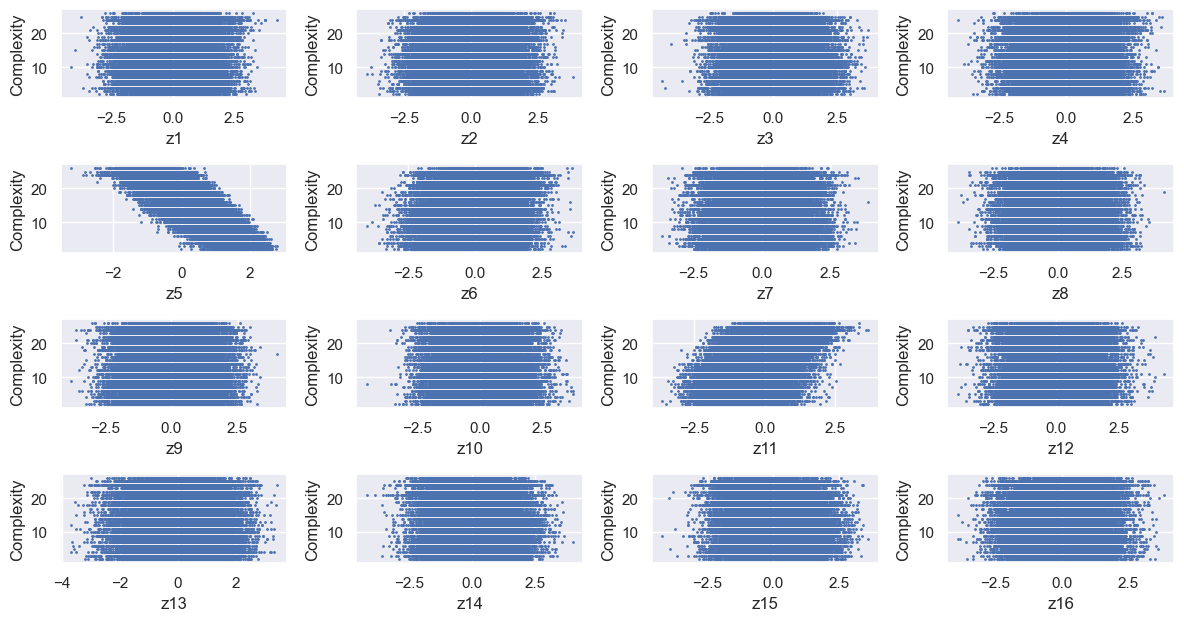

In [72]:
# Plot latent variables against complexity
plt.figure(figsize=(12,9))

for i in range(latent_dim):
    plt.subplot(6, 4, i+1)
    plt.scatter(z[:,i], Y, s=1)
    plt.xlabel(f"z{i+1}")
    plt.ylabel("Complexity")
plt.tight_layout()

Path finding algorithm

In [73]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.finder.breadth_first import BreadthFirstFinder

def replace_char(char):
    if char == '+' or char == '-' or char == '|' or char == '#':
        return [125, 125, 125]
    elif char == 's':
        return [255, 0, 0]
    elif char == 'e':
        return [0, 255, 0]
    elif char == 'x':
        return [0, 0, 255]
    else:
        return [0, 0, 0]

def get_shortest_path(grid, pos):
    """Get the shortest path from the start to the end

    Args:
    grid (np.array): 2D grid where 0 is free space and 1 is obstacle
    pos (tuple): Start and end position in the grid (start_x, start_y, end_x, end_y)

    Returns:
    list: List of tuples with the shortest path from start to end
    """
    pos = np.clip(pos, 0, 14)

    start, end = pos[:2], pos[2:]
    maze = np.abs(grid - 1)

    # Ensure start and end are free
    maze[start[1], start[0]] = 1
    maze[end[1], end[0]] = 1
    
    grid = Grid(matrix=maze)
    start = grid.node(start[0], start[1])
    end = grid.node(end[0], end[1])
    
    finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
    path, runs = finder.find_path(start, end, grid)

    return path

In [ ]:
idx = random.randint(0, len(X)-1)
idx = i

maze = np.ceil(X[idx]/255).mean(axis=-1).astype(int)
positions = np.round(Y[idx]*7 + 7).astype(int)
maze[positions[1], positions[0]] = 0
maze[positions[3], positions[2]] = 0

path = get_shortest_path(maze, positions)
path = [(p.y, p.x) for p in path]

In [120]:
# Replace start and end
maze = (np.stack([maze]*3, axis=-1) * 125).astype(np.int16)
maze[positions[1], positions[0]] = [255, 0, 0]
maze[positions[3], positions[2]] = [0, 255, 0]

plt.subplot(121)
plt.imshow(maze)
plt.grid(False)
plt.axis('off')

plt.subplot(122)
# Replace path
for p in path[1:-1]:
    maze[p[0], p[1]] = [0, 0, 255]

plt.imshow(maze)
plt.grid(False)
plt.axis('off')

print("Path length:", len(path))

IndexError: invalid index to scalar variable.

Calculate path length of all grids

In [582]:
path_lengths = []

for i in range(X.shape[0]):
    maze = np.ceil(X[i]/255).mean(axis=-1).astype(int)
    positions = np.round(Y[i]*7 + 7).astype(int)
    maze[positions[1], positions[0]] = 0
    maze[positions[3], positions[2]] = 0

    path = get_shortest_path(maze, positions)

    path_lengths.append(len(path))
    
    print(f"Processed {i+1}/{X.shape[0]}", end="\r")

path_lengths = np.array(path_lengths)

In [594]:
np.save("path_lengths.npy", path_lengths)

In [514]:
zero_length_idxs = np.where(path_lengths == 0)[0]

Text(0.5, 1.0, 'Grid 25182')

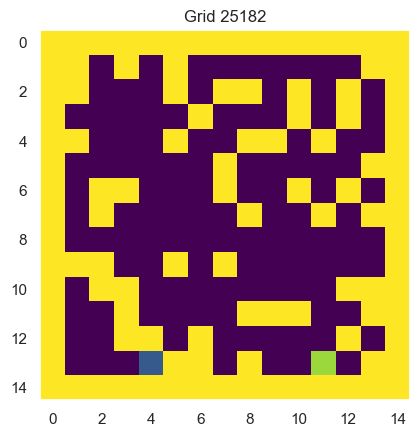

In [517]:
idx = np.random.choice(zero_length_idxs)

plt.imshow(X[idx, ..., 0], cmap='viridis')
plt.grid(False)
plt.title(f"Grid {idx}")

Analyze latent space

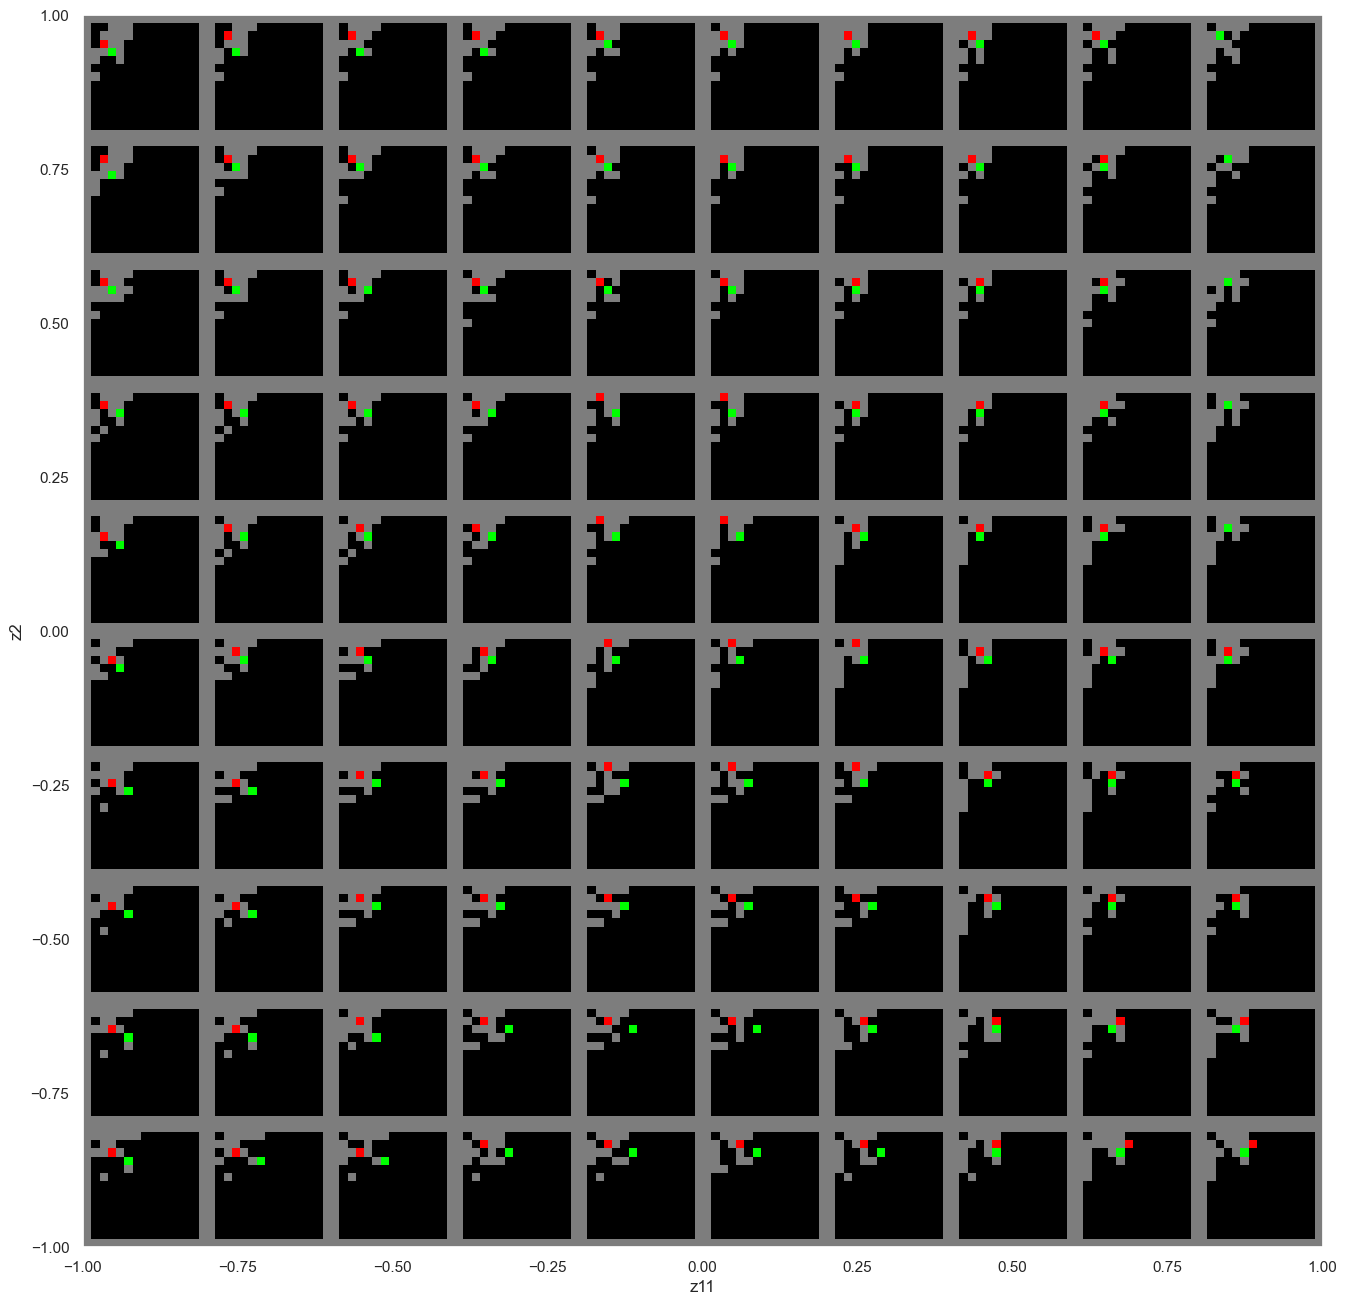

In [77]:
latent_dim = 16

# Generate vector with random values
z_ = np.random.rand(1, latent_dim)

# Shortest path length
path_length_ = 2
path_length_ = torch.tensor([path_length_]).to(device).float()

# Number of grids to plot in each dimension
n = 10

# Latent variables to vary
c0 = 2
c1 = 11

# Limits
r0 = (-1, 1)
r1 = (-1, 1)

img_size = (15, 15)
w = img_size[0]
img = np.zeros((n*w, n*w,3)).astype(np.uint8)

plt.figure(figsize=(16,16))
# Variate the first element of the vector
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z = z_.copy()
        z[0,c0] = x
        z[0,c1] = y
        z = torch.tensor(z).to(device).ravel().float()
        z = torch.cat([z, path_length_], dim=-1)
        recon_x = vae_model.decoder(z)
        # Reconstruct image using VAE
        recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
        grid_img = generate_grid_image(recon_x)
        
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w, :] = grid_img.astype(np.uint8)

plt.imshow(img, extent=[*r1, *r0], aspect="auto")
plt.grid(False)
plt.xlabel(f"z{c1}")
plt.ylabel(f"z{c0}")
plt.show()

In [30]:
# Generate easy grid and hard grid
easy = 3
hard = 25

# Interpolate between easy and hard grid
n = 1000
z_ = np.random.rand(n, latent_dim+1)
z_[:, -1] = np.linspace(easy, hard, n)

grids = []
for i in range(n):
    z = torch.tensor(z_[i]).to(device).ravel().float()
    recon_x = vae_model.decoder(z)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
    grid_img = generate_grid_image(recon_x)
    grids.append(grid_img)

In [31]:
import imageio
# Create a gif from the images
imageio.mimsave(f'vae_{latent_dim}_latent_space.gif', grids, duration=200, format="GIF")

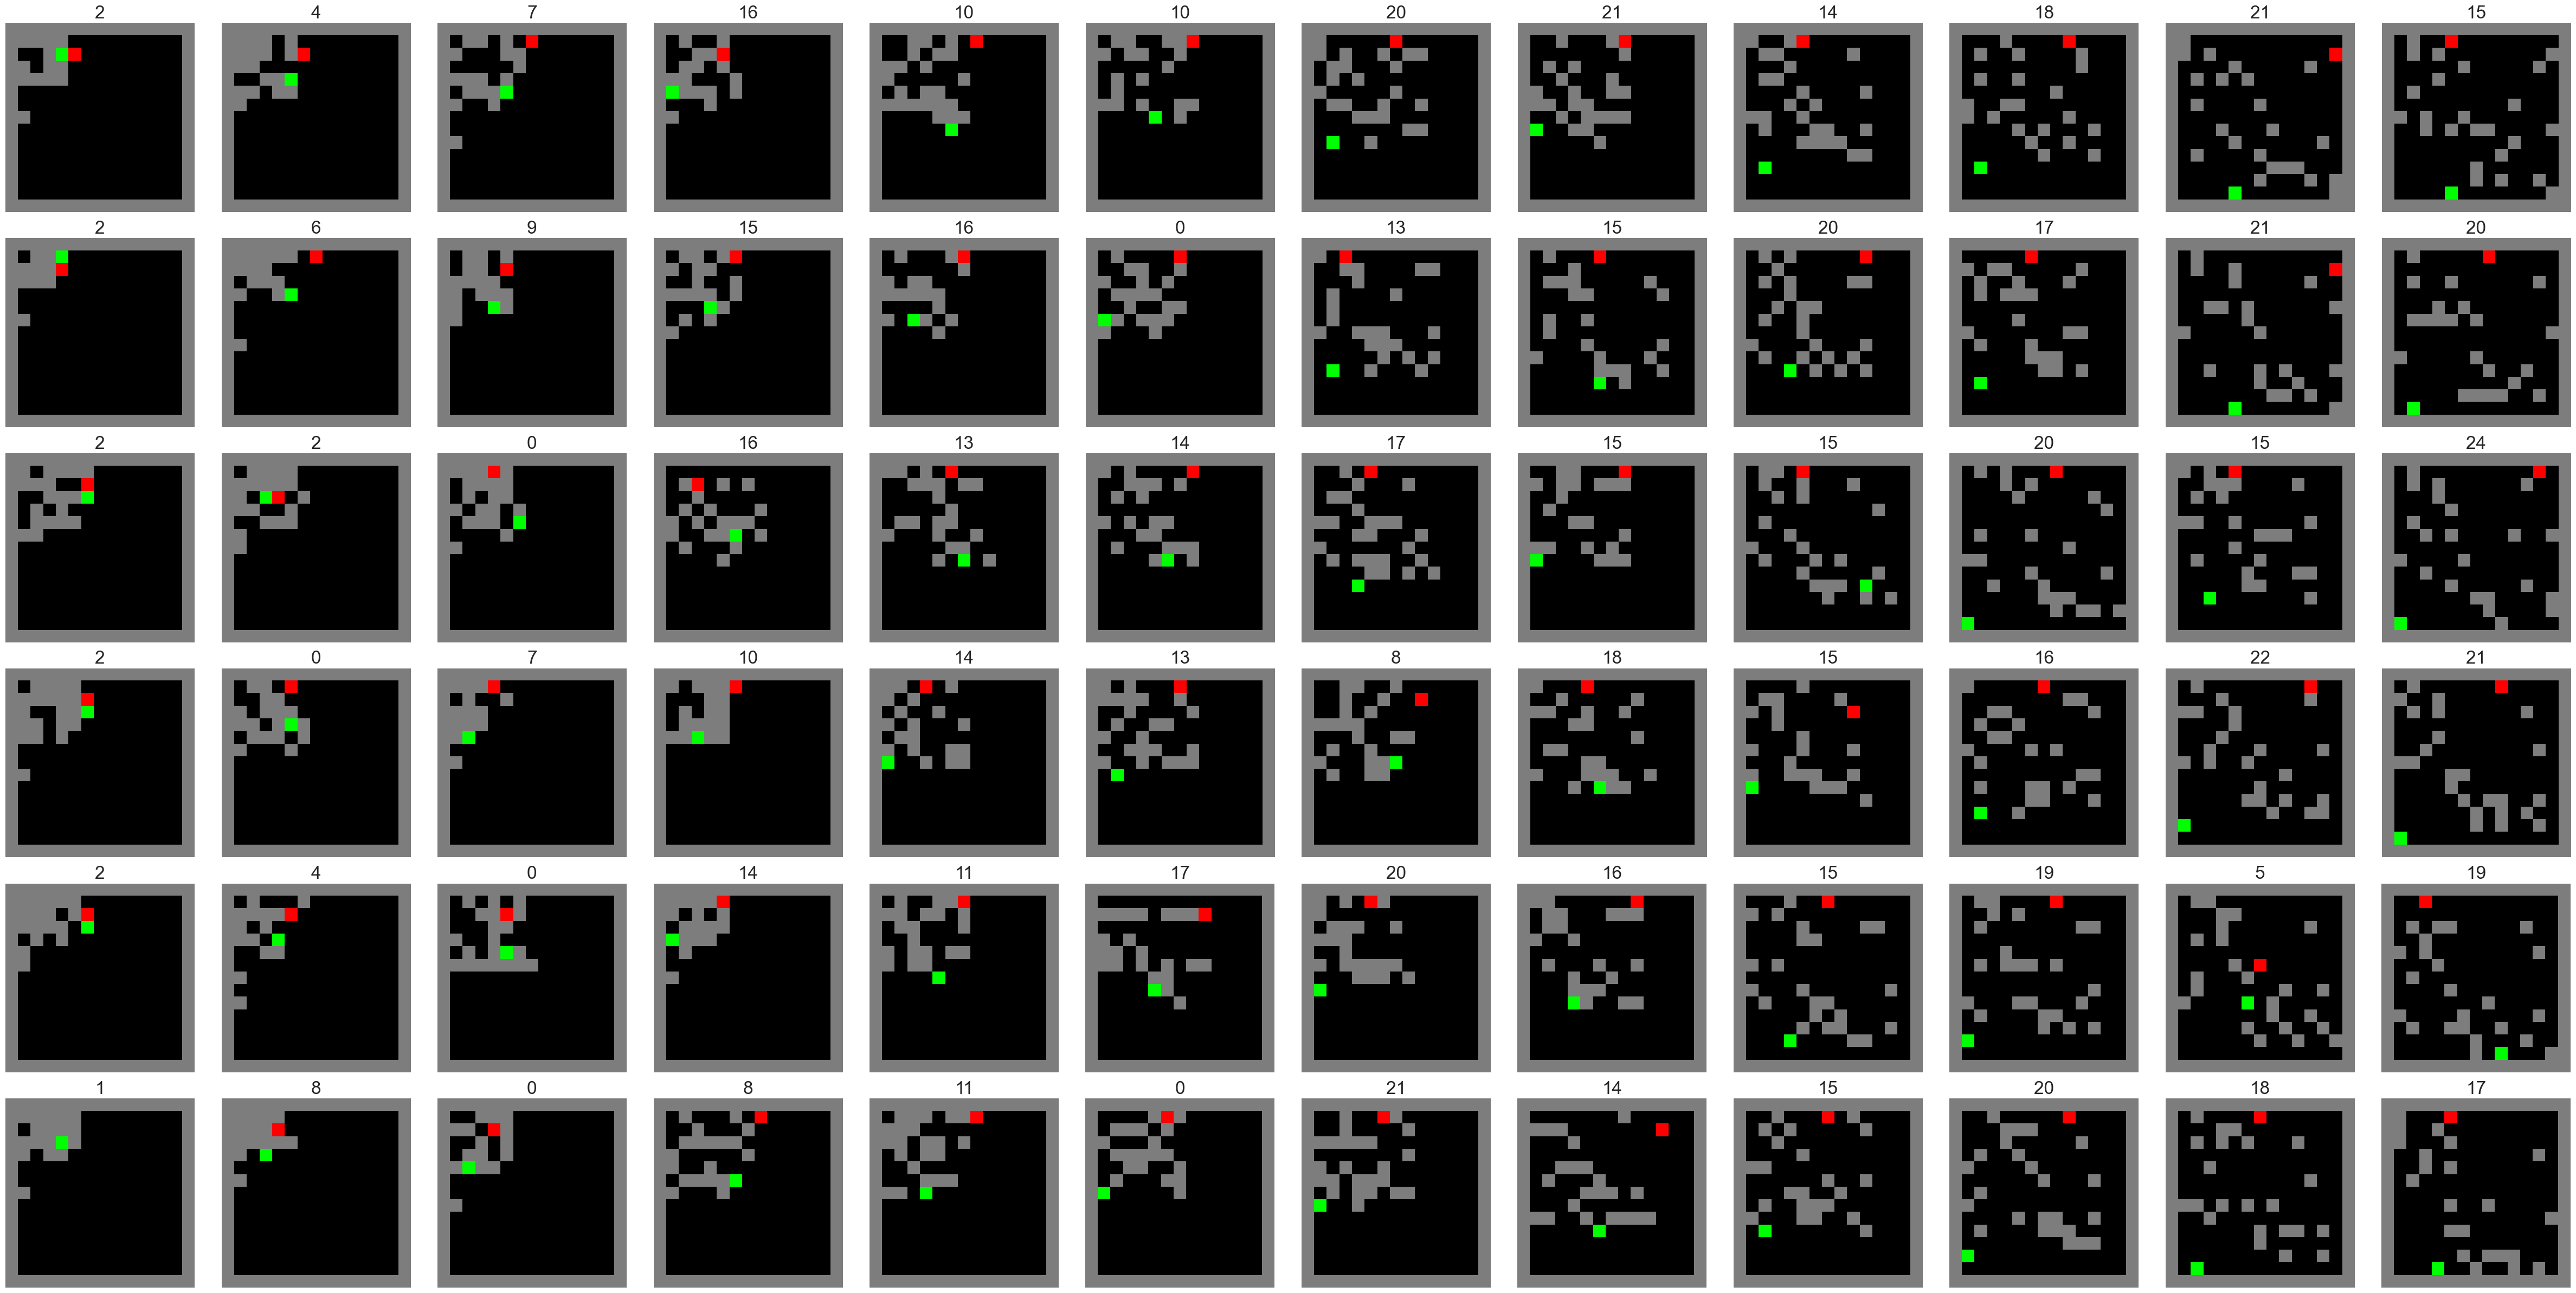

In [78]:
# Plot grids with increasing shortest path length
n_path_lengths = 11
min_path_length, max_path_length = 2, 25
path_lengths = range(min_path_length, max_path_length, (max_path_length-min_path_length)//(n_path_lengths-1))
n_grids = 6
img_size = (15, 15)
w, h = img_size[0], img_size[1]

plt.figure(figsize=(4*len(path_lengths), 4*n_grids))

path_lengths_ = [[] for _ in range(n_grids)]

for i in range(n_grids):
    for j, c in enumerate(path_lengths):
        z = np.random.rand(1, latent_dim)
        z = np.append(z, c)
        z = torch.tensor(z).to(device).ravel().float()
        # Reconstruct image using VAE
        recon_x = vae_model.decoder(z).to('cpu').detach().numpy().squeeze().reshape(-1,2).astype(np.int32)
        plt.subplot(n_grids, len(path_lengths), i*len(path_lengths)+j+1)
        grid_img = generate_grid_image(recon_x)
        grid_img_ = generate_grid_image(recon_x, start_goal=False)

        maze = np.ceil(grid_img_/255).mean(axis=-1).astype(int)
        positions = recon_x[-2:].ravel() + 1  # Add 1 to account for outer walls

        path = get_shortest_path(maze, positions)
        path_length_ = len(path)

        path_lengths_[i].append(path_length_)

        plt.imshow(grid_img)
        plt.grid(False)
        plt.axis('off')
        plt.title(f"{path_length_}", fontsize=24)

plt.tight_layout()

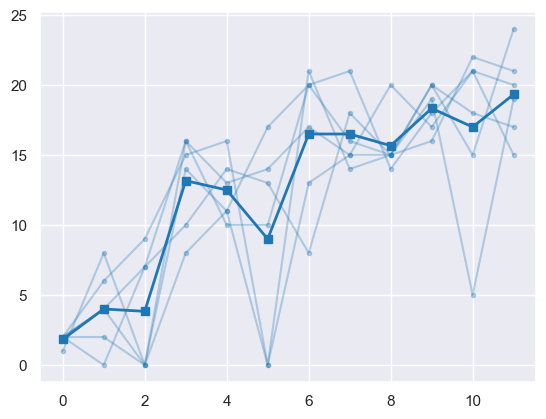

In [80]:
path_lengths_mean = np.mean(path_lengths_, axis=0)

for i in range(n_grids):
    plt.plot(path_lengths_[i], marker=".", color="tab:blue", alpha=0.3)

plt.plot(path_lengths_mean, marker="s", color="tab:blue", linewidth=2)

Path length: 13


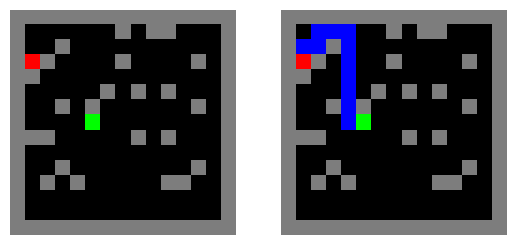

In [168]:
plt.subplot(121)
plt.imshow(grid_img_zero)
plt.grid(False)
plt.axis('off')

plt.subplot(122)
maze = np.copy(grid_img_zero)
path_zero = get_shortest_path(maze_zero, positions_zero)
# Replace path
for p in path_zero[1:-1]:
    p = (p.x, p.y)
    maze[p[1], p[0]] = [0, 0, 255]

plt.imshow(maze)
plt.grid(False)
plt.axis('off')

print("Path length:", len(path_zero))